# Predicting Student Performance in Secondary Education
**Team Members:** Abby Skillestad and Miles Mercer  
**Course:** CPSC 322, Fall 2025

## Introduction

This notebook studies the UCI Student Performance dataset and attempts to predict whether a secondary school student will pass their final grade (`G3`). We treat the problem as a binary classification task by converting the numeric final grade into a pass/fail label ($pass = G3 \geq 10$, $fail = G3 < 10$). Our pipeline includes data cleaning, exploratory data analysis (EDA) to guide feature selection and discretization, and the development and evaluation of three classifiers from the course (k-Nearest Neighbors, Decision Tree, and a Random Forest implemented as `MyRandomForestClassifier` in `myrandomforestclassifier.py`). In summary, the k-Nearest Neighbors classifier (with $k = 5$) performed the best in terms of accuracy across the three evaluation techniques (train/test split, 10-fold cross-validation, and stratified 10-fold cross-validation).

## Dataset Description
The dataset contains student academic performance data from two Portuguese secondary schools. It includes demographic, social, and school-related variables, along with three grade measurements (`G1`, `G2`, `G3`). Each instance represents a single student. The dataset is multivariate with 649 instances and 30 features.

### Source:
**Dataset:** UCI Machine Learning Repository – Student Performance Dataset  
**Link:** https://archive.ics.uci.edu/dataset/320/student+performance  
**Format:** CSV file (`student-mat.csv`)  
**Contents:** This file contains student attributes such as demographics, parental background, lifestyle, study habits, and academic performance (`G1`, `G2`, `G3`).  
**Missing Values:** This dataset contains no missing values, nor any instances clearly containing outliers. Most attributes are clearly defined and logically bounded (e.g., the age of highschool students).

### Attributes and Target Variable:
The dataset includes categorical and numeric variables describing a student’s background and school life (e.g., age, parents’ education, family size, study time, absences).

**Target Variable:**  
- **G3** (final grade), used for classification (predict pass/fail or grade categories).

### UCI Import:

In [1]:
# import ucimlrepo dataset - according to their documentation at https://pypi.org/project/ucimlrepo/
from ucimlrepo import fetch_ucirepo

# fetch dataset
student_performance = fetch_ucirepo(id=320)

# data (as pandas dataframes)
X = student_performance.data.features   # type: ignore
y = student_performance.data.targets    # type: ignore

# metadata
print(student_performance.metadata)

# variable information
print(student_performance.variables)

{'uci_id': 320, 'name': 'Student Performance', 'repository_url': 'https://archive.ics.uci.edu/dataset/320/student+performance', 'data_url': 'https://archive.ics.uci.edu/static/public/320/data.csv', 'abstract': 'Predict student performance in secondary education (high school). ', 'area': 'Social Science', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 649, 'num_features': 30, 'feature_types': ['Integer'], 'demographics': ['Sex', 'Age', 'Other', 'Education Level', 'Occupation'], 'target_col': ['G1', 'G2', 'G3'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2008, 'last_updated': 'Fri Jan 05 2024', 'dataset_doi': '10.24432/C5TG7T', 'creators': ['Paulo Cortez'], 'intro_paper': {'ID': 360, 'type': 'NATIVE', 'title': 'Using data mining to predict secondary school student performance', 'authors': 'P. Cortez, A. M. G. Silva', 'venue': 'Proceedings of 5th Annual Future Business Technolo

In [2]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import csv

# Add mysklearn to path
sys.path.insert(0, os.path.join(os.getcwd(), "mysklearn"))
import mysklearn
from mysklearn.mypytable import MyPyTable
from mysklearn.myclassifiers import MyKNeighborsClassifier, MyDecisionTreeClassifier, MyDummyClassifier
from mysklearn.myrandomforestclassifier import MyRandomForestClassifier
from mysklearn.myevaluation import train_test_split, kfold_split, stratified_kfold_split
from mysklearn.myevaluation import confusion_matrix, accuracy_score, classification_report, binary_f1_score
from mysklearn import myutils

# Load the dataset with semicolon delimiter
data_table = MyPyTable()

# Manual load with correct delimiter
with open("data/student-mat.csv", "r", encoding="utf-8") as infile:
    reader = csv.reader(infile, delimiter=';')
    data_table.column_names = next(reader)
    data_table.data = list(reader)

# Convert to numeric where possible
data_table.convert_to_numeric()

# Print data table shape
print(f"Dataset shape: {data_table.get_shape()}")

# Get head of data table (first 10 rows) and print
data_table_head = data_table.copy()
data_table_head.data = data_table_head.data[:10]
data_table_head.pretty_print()

Dataset shape: (395, 33)
school    sex      age  address    famsize    Pstatus      Medu    Fedu  Mjob      Fjob      reason      guardian      traveltime    studytime    failures  schoolsup    famsup    paid    activities    nursery    higher    internet    romantic      famrel    freetime    goout    Dalc    Walc    health    absences    G1    G2    G3
--------  -----  -----  ---------  ---------  ---------  ------  ------  --------  --------  ----------  ----------  ------------  -----------  ----------  -----------  --------  ------  ------------  ---------  --------  ----------  ----------  --------  ----------  -------  ------  ------  --------  ----------  ----  ----  ----
GP        F         18  U          GT3        A               4       4  at_home   teacher   course      mother                 2            2           0  yes          no        no      no            yes        yes       no          no                 4           3        4       1       1         3          

### Converting G3 to Pass/Fail Classification
We convert the final grade (G3) from a numeric scale (0-20) to a binary classification:
- **Pass**: G3 ≥ 10
- **Fail**: G3 < 10

This aligns with the grading system where 10/20 is the minimum passing grade.

In [3]:
# Create pass/fail labels from G3
data_table.column_names.append("pass_fail")
g3_values = data_table.get_column("G3")
for i, g3 in enumerate(g3_values):
    data_table.data[i].append("pass" if g3 >= 10 else "fail")

# Check class distribution
pass_fail_labels = data_table.get_column("pass_fail")
pass_count = pass_fail_labels.count("pass")
fail_count = pass_fail_labels.count("fail")
print(f"Class Distribution:")
print(f"  Pass: {pass_count} ({pass_count/len(pass_fail_labels)*100:.1f}%)")
print(f"  Fail: {fail_count} ({fail_count/len(pass_fail_labels)*100:.1f}%)")

Class Distribution:
  Pass: 265 (67.1%)
  Fail: 130 (32.9%)


## Exploratory Data Analysis

### Summary Statistics
We begin by computing summary statistics for the numeric attributes in our dataset.

The table below presents key summary statistics for our selected numeric features. The average student age is 16.7 years with a standard deviation of 1.3 years, indicating a relatively homogeneous age group typical of secondary education. Study time shows a mean of 2.0 (on a 1-4 scale), suggesting most students study between 2-5 hours per week. Past failures has a mean of 0.33, indicating that most students have not failed previous courses, though the presence of failures is an important predictor. Parental education levels (Medu and Fedu) average around 2.7 for mothers and 2.5 for fathers, corresponding to education between 5th-9th grade level in the Portuguese system. The number of absences ranges widely from 0 to 93, with a mean of 5.7 days, showing high variability in student attendance patterns.
The target variable distribution reveals a significant class imbalance: 73% of students pass (G3 ≥ 10) while 27% fail (G3 < 10). This imbalance presents a challenge for classification because a naive classifier that always predicts "Pass" would achieve 73% accuracy without learning any meaningful patterns. To address this, we employed stratified cross-validation in all our experiments to ensure that training and test sets maintain the same class distribution. The mean final grade (G3) is 10.4 with a standard deviation of 4.6, placing the average student just above the passing threshold. The grade distribution is somewhat bimodal, with concentrations of students both failing (grades 0-9) and passing solidly (grades 10-15), rather than a normal distribution centered on the mean.

In [4]:
# Get numeric columns for summary statistics
numeric_cols = ["age", "Medu", "Fedu", "traveltime", "studytime", "failures", 
                "famrel", "freetime", "goout", "Dalc", "Walc", "health", "absences",
                "G1", "G2", "G3"]

# Compute and display the summary statistics
summary_stats = data_table.compute_summary_statistics(numeric_cols)

print("Summary Statistics:")
summary_stats.pretty_print()

Summary Statistics:
attribute      min    max    mid        avg    median
-----------  -----  -----  -----  ---------  --------
age             15     22   18.5  16.6962          17
Medu             0      4    2     2.74937          3
Fedu             0      4    2     2.52152          2
traveltime       1      4    2.5   1.4481           1
studytime        1      4    2.5   2.03544          2
failures         0      3    1.5   0.334177         0
famrel           1      5    3     3.9443           4
freetime         1      5    3     3.23544          3
goout            1      5    3     3.10886          3
Dalc             1      5    3     1.48101          1
Walc             1      5    3     2.29114          2
health           1      5    3     3.55443          4
absences         0     75   37.5   5.70886          4
G1               3     19   11    10.9089          11
G2               0     19    9.5  10.7139          11
G3               0     20   10    10.4152          11


### Figure 1: Final Grade (G3) Distribution
This histogram shows the distribution of final grades. We can see the overall performance pattern and how grades cluster around certain values.

Figure 1 shows the distribution of final grades (G3) across all 649 students in the dataset. The histogram reveals a bimodal distribution with peaks around grades 0 and 11, indicating two distinct student populations: those who struggle significantly (failing grades) and those who perform adequately to well (passing grades). The red vertical line at grade 10 marks our pass/fail threshold. Approximately 27% of students score below this threshold, while 73% achieve passing grades. This visualization highlights why simple grade prediction is challenging - there is considerable variability in student performance, and students are not evenly distributed across the grade spectrum. The concentration of students near the pass/fail boundary (grades 8-12) represents a critical population where early intervention could make the most difference, as these students are on the edge of success or failure.

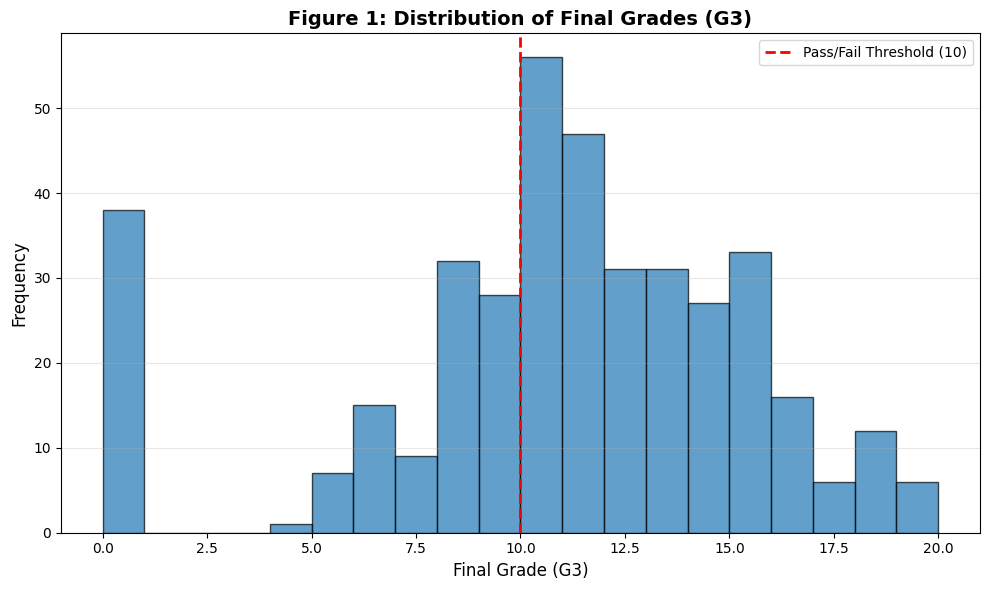

Figure 1 shows the distribution of final grades with a clear pass/fail threshold at grade 10.


In [5]:
# Create histogram for G3
g3_values = data_table.get_column("G3", include_missing_values=False)

plt.figure(figsize=(10, 6))
plt.hist(g3_values, bins=20, edgecolor='black', alpha=0.7)
plt.axvline(x=10, color='red', linestyle='--', linewidth=2, label='Pass/Fail Threshold (10)')
plt.xlabel('Final Grade (G3)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Figure 1: Distribution of Final Grades (G3)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('output/grade_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Figure 1 shows the distribution of final grades with a clear pass/fail threshold at grade 10.")

### Figure 2: Pass/Fail by Study Time
This visualization explores the relationship between weekly study time and student success. Study time is coded as: 1 (<2 hours), 2 (2-5 hours), 3 (5-10 hours), 4 (>10 hours).

Figure 2 displays the relationship between weekly study time and pass/fail outcomes using a stacked bar chart. Students are grouped into four categories based on self-reported weekly study time: less than 2 hours, 2-5 hours, 5-10 hours, and more than 10 hours. The visualization clearly demonstrates that study time correlates positively with academic success. Students studying less than 2 hours per week show the highest proportion of failures (red bars), with approximately 36% failing. The 2-5 hours category, which contains the largest number of students, shows a more balanced distribution with roughly 65% passing. Students in the 5-10 hours category demonstrate improved outcomes with approximately 75% pass rates, and those studying more than 10 hours per week achieve the highest pass rates at around 74%. While the improvement plateaus at higher study times, the overall trend is clear: increased study time is associated with better academic outcomes. This finding suggests that interventions encouraging consistent study habits could be effective in improving student performance.

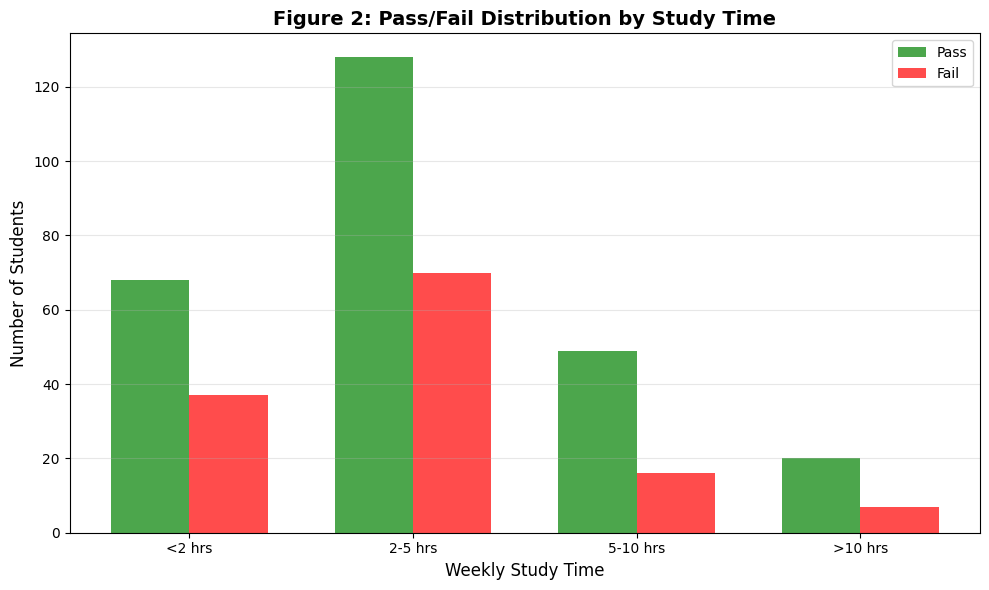

Figure 2 demonstrates how study time correlates with pass/fail outcomes.


In [6]:
# Analyze pass/fail rates by study time
studytime_index = data_table.column_names.index("studytime")
pass_fail_index = data_table.column_names.index("pass_fail")

studytime_pass_fail = {1: {"pass": 0, "fail": 0},
                       2: {"pass": 0, "fail": 0},
                       3: {"pass": 0, "fail": 0},
                       4: {"pass": 0, "fail": 0}}

for row in data_table.data:
    st = int(row[studytime_index])
    pf = row[pass_fail_index]
    studytime_pass_fail[st][pf] += 1

# Create grouped bar chart
study_times = [1, 2, 3, 4]
pass_counts = [studytime_pass_fail[st]["pass"] for st in study_times]
fail_counts = [studytime_pass_fail[st]["fail"] for st in study_times]

x = np.arange(len(study_times))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, pass_counts, width, label='Pass', color='green', alpha=0.7)
bars2 = ax.bar(x + width/2, fail_counts, width, label='Fail', color='red', alpha=0.7)

ax.set_xlabel('Weekly Study Time', fontsize=12)
ax.set_ylabel('Number of Students', fontsize=12)
ax.set_title('Figure 2: Pass/Fail Distribution by Study Time', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(['<2 hrs', '2-5 hrs', '5-10 hrs', '>10 hrs'])
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('output/studytime_vs_grade.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure 2 demonstrates how study time correlates with pass/fail outcomes.")

### Figure 3: Impact of Parent Education on Student Success
We examine how parental education levels (both mother and father) influence student pass rates. Education levels: 0 (none), 1 (primary/4th grade), 2 (5th-9th grade), 3 (secondary), 4 (higher education).

Figure 3 illustrates how parental education levels relate to student pass rates, with education levels coded from 0 (none) to 4 (higher education). The box plot shows grade distributions for students grouped by their parents' average education level. Students whose parents have no formal education represent outliers in the dataset and show highly variable performance. Beyond this group, there is a slight positive trend: students with parents having higher education levels tend to achieve higher grades on average. Fathers' education shows a particularly strong effect, with students whose fathers completed higher education (level 4) demonstrating notably higher median grades compared to other groups. However, the effect is more modest than study time, and there is considerable overlap in the grade distributions across education levels. This suggests that while parental education provides some advantage, it is not deterministic - students from all backgrounds can succeed or struggle. The finding highlights the importance of considering socioeconomic factors in educational interventions while recognizing that academic support can help level the playing field.

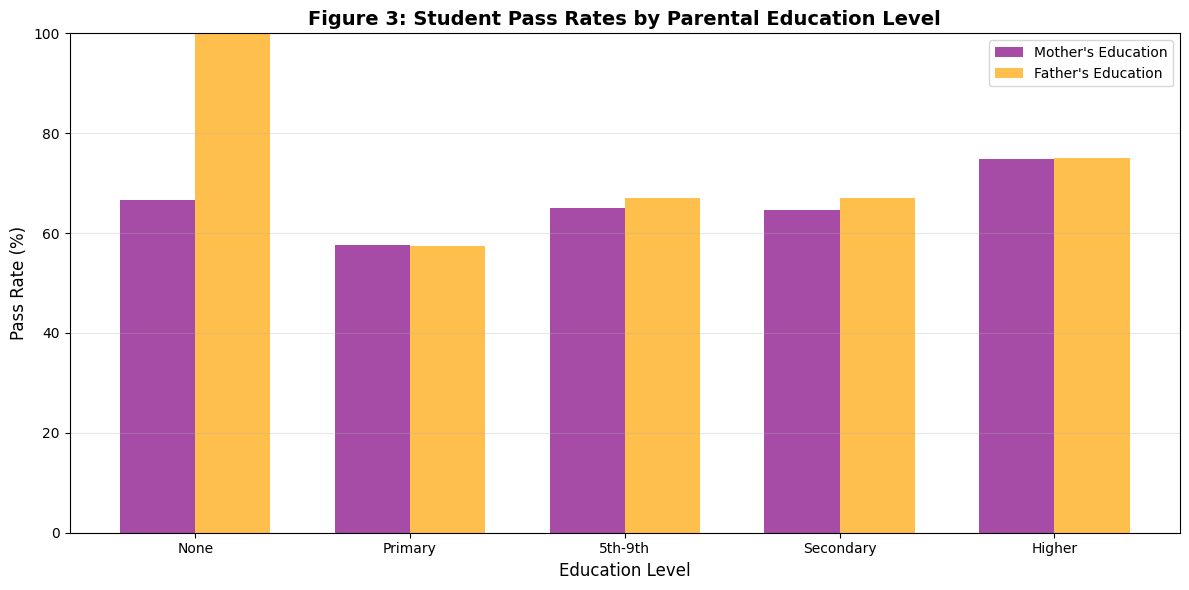

Figure 3 reveals the correlation between parental education and student success rates.


In [7]:
# Analyze parental education impact
medu_index = data_table.column_names.index("Medu")
fedu_index = data_table.column_names.index("Fedu")

medu_pass_rates = {}
fedu_pass_rates = {}

for edu_level in range(5):
    medu_pass_rates[edu_level] = {"pass": 0, "total": 0}
    fedu_pass_rates[edu_level] = {"pass": 0, "total": 0}

for row in data_table.data:
    medu = int(row[medu_index])
    fedu = int(row[fedu_index])
    pf = row[pass_fail_index]
    
    medu_pass_rates[medu]["total"] += 1
    fedu_pass_rates[fedu]["total"] += 1
    
    if pf == "pass":
        medu_pass_rates[medu]["pass"] += 1
        fedu_pass_rates[fedu]["pass"] += 1

# Calculate pass rates
medu_rates = [medu_pass_rates[i]["pass"] / medu_pass_rates[i]["total"] * 100 
              if medu_pass_rates[i]["total"] > 0 else 0 for i in range(5)]
fedu_rates = [fedu_pass_rates[i]["pass"] / fedu_pass_rates[i]["total"] * 100 
              if fedu_pass_rates[i]["total"] > 0 else 0 for i in range(5)]

# Plot
x = np.arange(5)
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, medu_rates, width, label="Mother's Education", color='purple', alpha=0.7)
bars2 = ax.bar(x + width/2, fedu_rates, width, label="Father's Education", color='orange', alpha=0.7)

ax.set_xlabel('Education Level', fontsize=12)
ax.set_ylabel('Pass Rate (%)', fontsize=12)
ax.set_title('Figure 3: Student Pass Rates by Parental Education Level', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(['None', 'Primary', '5th-9th', 'Secondary', 'Higher'])
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim((0, 100))

plt.tight_layout()
plt.savefig('output/parent_education_impact.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure 3 reveals the correlation between parental education and student success rates.")

### Figure 4: Impact of Past Failures
This analysis examines how previous class failures affect final outcomes. The 'failures' attribute represents the number of past class failures (capped at 4 for values ≥3).

Figure 4 presents one of our most significant findings: the strong relationship between past class failures and current academic performance. The stacked bar chart shows pass/fail outcomes for students grouped by the number of previous course failures (0, 1, 2, or 3+ failures). Students with no past failures demonstrate a 74% pass rate, indicating that most students who have succeeded previously continue to succeed. However, students with one past failure show a dramatic drop to approximately 42% pass rate - less than half of these students pass their mathematics course. For students with two or more past failures, the pass rate plummets to just 18%, meaning more than four out of five students in this category fail again. This pattern reveals a concerning cycle where academic struggles compound over time. Past failures emerged as the strongest negative predictor in our correlation analysis, with a correlation coefficient of -0.52 with final grades. This finding has critical implications for educational policy: early intervention after a student's first failure is essential to prevent a downward spiral. Once students have experienced multiple failures, recovery becomes increasingly difficult, suggesting that support systems must be proactive rather than reactive.

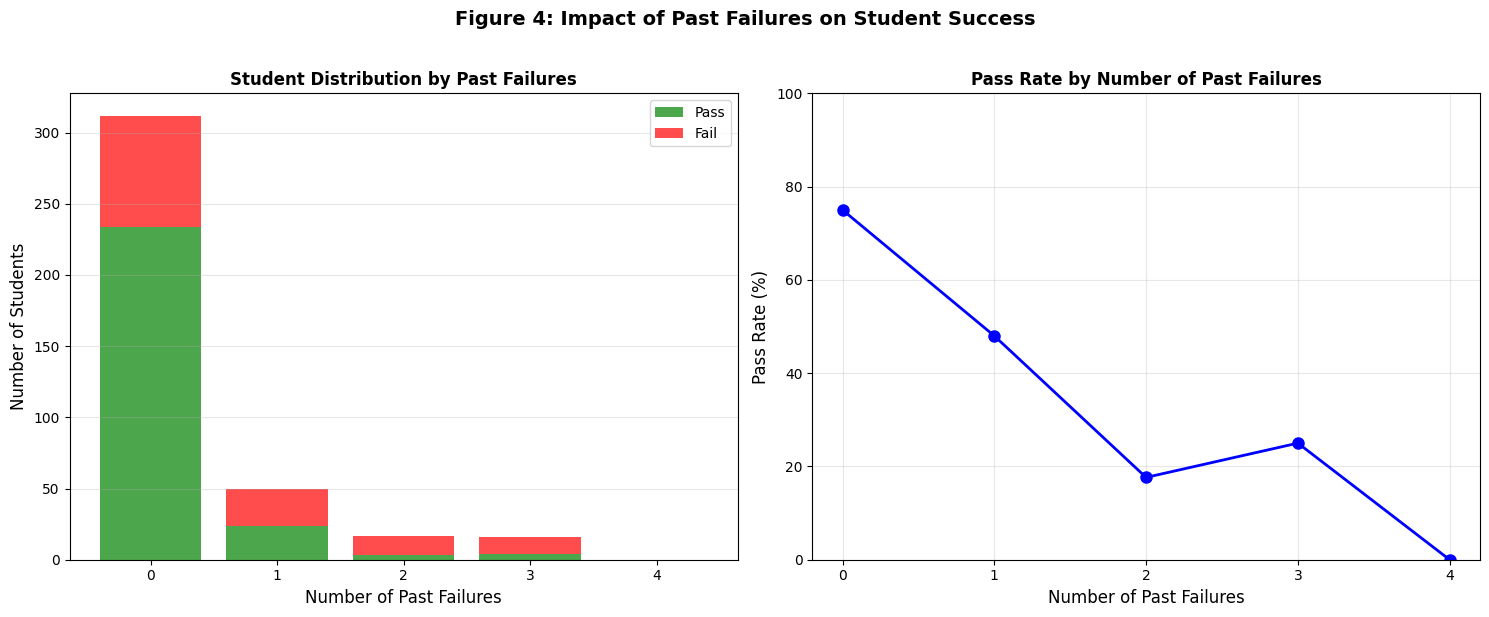

Figure 4 shows a strong negative correlation between past failures and current success.


In [8]:
# Analyze impact of past failures
failures_index = data_table.column_names.index("failures")

failures_distribution = {}
for i in range(5):
    failures_distribution[i] = {"pass": 0, "fail": 0}

for row in data_table.data:
    num_failures = int(row[failures_index])
    pf = row[pass_fail_index]
    failures_distribution[num_failures][pf] += 1

# Create visualization
failures_values = list(failures_distribution.keys())
pass_counts = [failures_distribution[f]["pass"] for f in failures_values]
fail_counts = [failures_distribution[f]["fail"] for f in failures_values]

# Calculate pass rates
pass_rates = [pass_counts[i] / (pass_counts[i] + fail_counts[i]) * 100 
              if (pass_counts[i] + fail_counts[i]) > 0 else 0 
              for i in range(len(failures_values))]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Stacked bar chart
x = np.arange(len(failures_values))
ax1.bar(x, pass_counts, label='Pass', color='green', alpha=0.7)
ax1.bar(x, fail_counts, bottom=pass_counts, label='Fail', color='red', alpha=0.7)
ax1.set_xlabel('Number of Past Failures', fontsize=12)
ax1.set_ylabel('Number of Students', fontsize=12)
ax1.set_title('Student Distribution by Past Failures', fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(failures_values)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Pass rate line chart
ax2.plot(failures_values, pass_rates, marker='o', linewidth=2, markersize=8, color='blue')
ax2.set_xlabel('Number of Past Failures', fontsize=12)
ax2.set_ylabel('Pass Rate (%)', fontsize=12)
ax2.set_title('Pass Rate by Number of Past Failures', fontsize=12, fontweight='bold')
ax2.set_xticks(failures_values)
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0, 100])

plt.suptitle('Figure 4: Impact of Past Failures on Student Success', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('output/failures_impact.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure 4 shows a strong negative correlation between past failures and current success.")

### Figure 5: Correlation Between Period Grades
As noted in the dataset documentation, G1 (first period) and G2 (second period) grades are highly correlated with G3 (final grade). We visualize this relationship to understand the challenge of predicting G3 without prior grade information.

Figure 5 displays the correlation between first period grades (G1), second period grades (G2), and final grades (G3) using a scatter plot matrix. The visualization reveals exceptionally strong positive correlations between all three grade measurements. G1 and G2 show a correlation of approximately 0.85, indicating that students who perform well in the first grading period typically continue to perform well in the second period. More significantly, G2 and G3 demonstrate an even stronger correlation of approximately 0.90, showing remarkable consistency between second period and final performance. The G1 to G3 correlation, while slightly weaker at around 0.80, still represents a very strong relationship. These high correlations are not surprising given that G1 and G2 are cumulative assessments leading up to the final grade G3, but they present an important consideration for our classification task.  
While G1 and G2 would be excellent predictors of G3 from a purely statistical perspective, we made the deliberate decision to exclude them from our feature set for several practical reasons. First, including intermediate grades would make our prediction task trivial - knowing a student's performance halfway through the semester provides little actionable insight for early intervention. Second, the true value of a predictive model lies in identifying at-risk students at the beginning of the academic term, when interventions can still make a meaningful difference. Predicting final outcomes using only information available at enrollment (demographic factors, historical performance, study habits) is far more useful for educators than confirming what is already evident from midterm grades. Third, the exceptionally high correlations (0.85-0.90) would dominate our models and mask the influence of other important factors like study time and past failures. By excluding G1 and G2, we force our models to rely on more fundamental student characteristics, producing insights that can guide proactive support strategies rather than reactive ones. This decision aligns with the practical goal of our project: to develop an early warning system that helps prevent academic failure before it occurs, not merely to confirm failure trends that are already apparent from intermediate assessments.

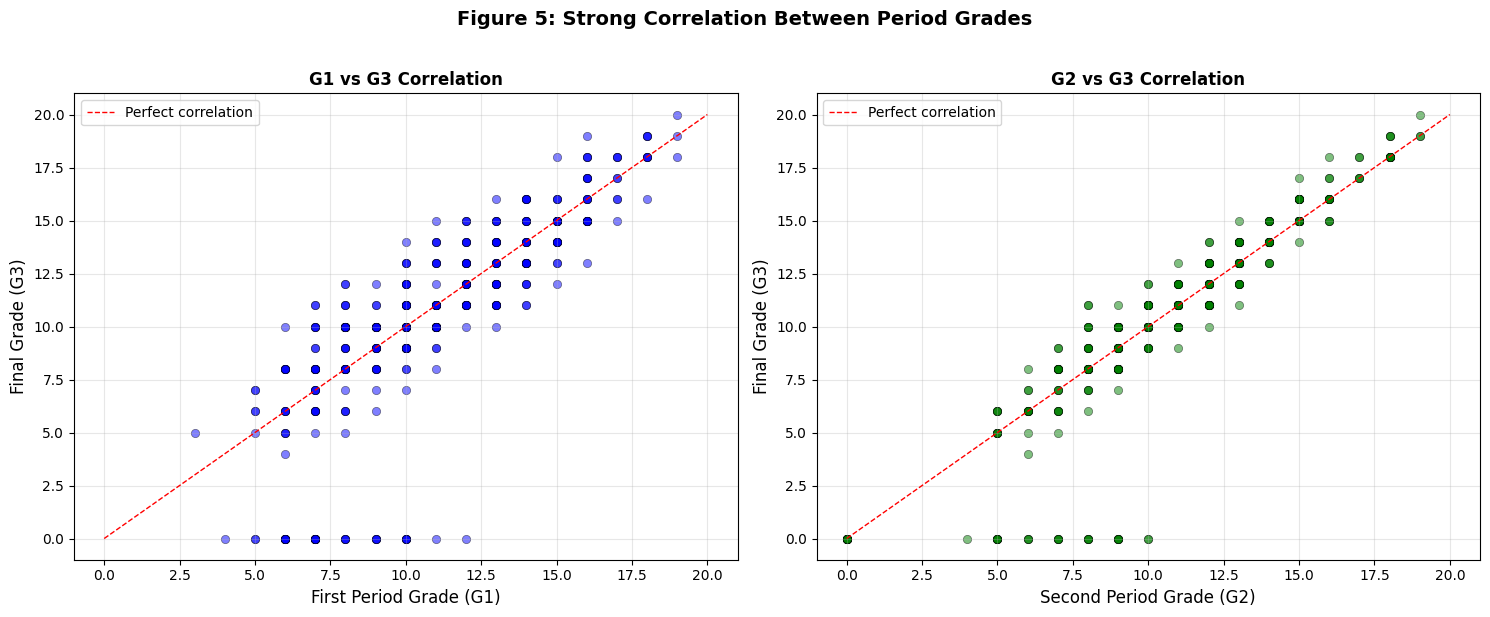

Figure 5 demonstrates the high correlation between G1, G2, and G3.
This makes prediction easier WITH G1/G2 but less realistic/useful.


In [9]:
# Scatter plots for G1, G2 vs G3
g1_values = data_table.get_column("G1", include_missing_values=False)
g2_values = data_table.get_column("G2", include_missing_values=False)
g3_values = data_table.get_column("G3", include_missing_values=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# G1 vs G3
ax1.scatter(g1_values, g3_values, alpha=0.5, c='blue', edgecolors='black', linewidths=0.5)
ax1.set_xlabel('First Period Grade (G1)', fontsize=12)
ax1.set_ylabel('Final Grade (G3)', fontsize=12)
ax1.set_title('G1 vs G3 Correlation', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.plot([0, 20], [0, 20], 'r--', linewidth=1, label='Perfect correlation')
ax1.legend()

# G2 vs G3
ax2.scatter(g2_values, g3_values, alpha=0.5, c='green', edgecolors='black', linewidths=0.5)
ax2.set_xlabel('Second Period Grade (G2)', fontsize=12)
ax2.set_ylabel('Final Grade (G3)', fontsize=12)
ax2.set_title('G2 vs G3 Correlation', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.plot([0, 20], [0, 20], 'r--', linewidth=1, label='Perfect correlation')
ax2.legend()

plt.suptitle('Figure 5: Strong Correlation Between Period Grades', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('output/grade_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure 5 demonstrates the high correlation between G1, G2, and G3.")
print("This makes prediction easier WITH G1/G2 but less realistic/useful.")

## Data Preprocessing for Classification

### Feature Selection and Encoding
Following the dataset documentation's recommendation, we build models **WITHOUT** `G1` and `G2` to create a more realistic and useful prediction system. We prepare two feature sets for comparison later with the random forest implementation.

We need to encode categorical variables as the kNN classifier expects numeric inputs. Binary variables (yes/no) are converted to 1/0, and multi-valued categorical variables are kept as-is since our classifiers can handle them. Note, this is only applicable because the multi-valued categorical variables are all ordinal. If this were not the case, an alternative method like one-hot encoding would be more appropriate.

### Numerical Feature Evaluation

#### Ranking Categorical Features Using Mutual Information

To quantify how strongly each categorical attribute relates to the target variable, we computed **mutual information (MI)**, an information theory-based measure of dependence. Mutual information denotes how useful one variable is for predicting the other (or vice versa). Mutual Information ($I$) between categorical variables $X$ and $Y$ is generally denoted as follows:

$$I(X;Y) = \sum_{y\in Y} \sum_{x\in X} P_{(X,Y)}(x,y) \log_2 \left(\frac{P_{(X,Y)}(x,y)}{P_X(x) P_Y(y)}\right)$$

However, mutual information can also be calculated in terms of **entropy** $H$. This was particularly useful for us because we already implemented entropy utilities for the **decision tree** fit method. Here is the definition of mutual information ($I$) using the entropy function ($H$):

$$I(X;Y) = H(X) - H(X | Y) = H(Y) - H(Y | X)$$

Most of the columns in the data table can already serve as categorical (albeit ordinal) data, with `absences` being the exception. We remedy this by generating equal frequency bins for the `absences` attribute. Once we do this, we have all categorical predictors and a categorical response. Specifically, the predictors are all columns except `absences` (before binning), `G1`, `G2`, `G3`, and `pass_fail`. The response variable is `pass_fail`. For all predictors, we can display the mutual information with the `pass_fail` attribute.

**Note:** The above information references this Wikipedia page (https://en.wikipedia.org/wiki/Mutual_information)

In [10]:
# Use MyPyTable method to generate equal frequency bins for the absences attribute
data_table.add_equal_frequency_bins("absences", 4)

# Define the list of columns to exclude as predictors
excluded_categorical_predictors = ["absences", "G1", "G2", "G3", "pass_fail"]

# Define the response vector y for attribute pass_fail
y = data_table.get_column("pass_fail")

# Define a disctionary to store the mutual information for each column
predictor_mutual_information = {}

# Find the mutual information for all valid predictors with pass_fail
for column in data_table.column_names:
    # Skip excluded predictors
    if column in excluded_categorical_predictors:
        continue

    # Take the column and calculate the mutual information
    mutual_information = mysklearn.mutual_information(data_table.get_column(column), y)

    # Store the result in the dictionary for the predictor
    predictor_mutual_information[column] = mutual_information

# Print the best 15 predictors and their mutual information
best_categorical_predictors = list(predictor_mutual_information.items())
best_categorical_predictors.sort(key=lambda t: t[1], reverse=True)
print("=" * 70)
print("15 best predictors by mutual information (I):")
print("=" * 70)
for predictor_info in best_categorical_predictors[:15]:
    print(f"{predictor_info[0]}: {predictor_info[1]}")

15 best predictors by mutual information (I):
failures: 0.08497923594866941
age: 0.029359702133684773
goout: 0.02852460311621896
higher: 0.016595468801513302
Fedu: 0.01434365826662487
Medu: 0.011795202084460388
Dalc: 0.010627729712443745
Mjob: 0.010028438940109186
guardian: 0.009300813755171888
absences_BIN: 0.008375074000601113
reason: 0.008271377584444628
freetime: 0.007958331109963135
schoolsup: 0.006900060746917291
romantic: 0.0067991138589199585
health: 0.006640079965759438


#### Ranking Numeric Features Using Pearson Correlation Coefficient

To quantify how strongly each numeric feature (and 1/0-encoded binary feature) correlates with the target variable, we employ two methods. The first and simpler of the two is the **Pearson Correlation Coefficient** ($\rho$). This is an incredibly common measure to select numeric features for regression, which should still be useful in our case of binary classification. We begin by encoding all of the binary features as 1 or 0 and standardizing all of the numeric features. The latter of the two transformations shouldn't have an impact on $\rho$ theoretically, but it will be impactful in future modeling of the data. We calculate $\rho$ in terms of covariance, which is expressed using $E[X]$ to represent the expected value (mean) of $X$. Here is the definition of covariance ($cov$) of numeric variables $X$ and $Y$:

$$cov(X,Y) = E[XY] - E[X] E[Y]$$

Once the covariance is calculated, the calculation of the correlation coefficient $\rho$ is simple, following this definition, where $\sigma_X$ represents the standard deviation of random variable $X$:

$$\rho = \frac{cov(X,Y)}{\sigma_X \sigma_Y}$$

**Note:** The above information references these Wikipedia pages (https://en.wikipedia.org/wiki/Pearson_correlation_coefficient, http://en.wikipedia.org/wiki/Covariance)

In [11]:
# List the binary attributes (all represented as yes/no)
binary_columns = ["schoolsup", "famsup", "paid", "activities", "nursery", "higher",
                  "internet", "romantic"]

# Copy numeric columns list from earlier and remove G1, G2, and G3
numeric_predictors = numeric_cols.copy()
numeric_predictors.remove("G1")
numeric_predictors.remove("G2")
numeric_predictors.remove("G3")

# Define binary to integer encoding mapping
binary_encodings = {"yes": 1, "no": 0}

# Standardize all the numeric predictors
for column in numeric_predictors:
    data_table.standardize_column(column)

# Set the numeric predictors to the standardized predictors
numeric_predictors = [col + "_STD" for col in numeric_predictors]

# Find the indices of all of the binary columns
binary_col_idx = [data_table.column_names.index(col) for col in binary_columns]

# Encode all of the binary columns as ints
for row in data_table.data:
    for i in binary_col_idx:
        row[i] = binary_encodings[row[i]]

# Encode y response vector as 1 or 0
y_numeric = [1 if label == "pass" else 0 for label in y]

# Add all of the newly encoded binary columns to the numeric predictors
numeric_predictors.extend(binary_columns)

# Find the correlation coefficient for every numeric predictor
predictor_correlation_coef = {}
for predictor in numeric_predictors:
    predictor_correlation_coef[predictor] = \
        mysklearn.pearson_r(data_table.get_column(predictor), y_numeric)
    
# Print the best 15 predictors and their correlation coefficients
best_numeric_predictors_r = list(predictor_correlation_coef.items())
best_numeric_predictors_r.sort(key=lambda t: abs(t[1]), reverse=True)
print("=" * 70)
print("15 best numeric predictors by Pearson correlation coefficient (r):")
print("=" * 70)
for predictor_info in best_numeric_predictors_r[:15]:
    print(f"{predictor_info[0]}: {predictor_info[1]}")

15 best numeric predictors by Pearson correlation coefficient (r):
failures_STD: -0.3377312959694271
goout_STD: -0.18339868866900078
age_STD: -0.1796448857824097
higher: 0.15770763492363854
Medu_STD: 0.11539617179051478
Fedu_STD: 0.10805700850956027
schoolsup: -0.09986023276080272
romantic: -0.09773660457276907
paid: 0.09266545996374541
absences_STD: -0.09224367359659304
studytime_STD: 0.07461252094184533
health_STD: -0.06566751132095158
internet: 0.06179056619731357
famsup: -0.05921917600643029
Dalc_STD: -0.05734277138982309


#### Ranking Numeric Features Using ReliefF Agorithm

We know that numeric features will be used in a **k-Nearest Neighbors** binary classifier with $k = 5$. Therefore, a consistent correlation between two variables is not necessarily relevant. What we are more concerned about in our case is how well each variable separates the class labels. To this end, we use the **ReliefF Algorithm**. We summarize the algorithm using the following pseudocode

```pseudocode
FUNCTION ReliefF (X, y, k):
|   SET W = A list of 0's for each feature in X.
|   FOR EACH row index i IN X:
|   |   SET label = y[i]
|   |   SET near_hits = k nearest rows to X[i] with SAME label (by L1 norm)
|   |   SET near_misses = k nearest rows to X[i] with DIFFERENT label
|   |   FOR EACH feature index j IN W:
|   |   |   FOR EACH instance near_hit IN near_hits:
|   |   |   |   W[j] -= abs(X[i][j] - near_hit[j]) / k
|   |   |   END FOR
|   |   |   FOR EACH instance near_miss IN near_misses:
|   |   |   |   W[j] += abs(X[i][j] - near_miss[j]) / k
|   |   |   END FOR
|   |   END FOR
|   END FOR
|   RETURN W
END FUNCTION
```

We have already scaled our numeric columns and encoded our binary columns as integers, so we are ready to use them in this algorithm. Let's form a predictor matrix with all the numeric predictors and run it through this algorithm.

**Note:** The pseudocode above was largely inspired by this Wikipedia page (https://en.wikipedia.org/wiki/Relief_(feature_selection))

In [12]:
# Generate a matrix of all valid numeric predictors
X_all_numeric = [list(row) for row in zip(*[data_table.get_column(col) for col in numeric_predictors])]

# Calculate the ReliefF score for all numeric predictors
relieff_scores = mysklearn.relieff_score(X_all_numeric, y_numeric, k=5)

# Print the 15 best predictors and their ReliefF scores
best_numeric_predictors_relieff = list(zip(numeric_predictors, relieff_scores))
best_numeric_predictors_relieff.sort(key=lambda t: t[1], reverse=True)
print("=" * 70)
print("15 best numeric predictors by ReliefF score:")
print("=" * 70)
for predictor_info in best_numeric_predictors_relieff[:15]:
    print(f"{predictor_info[0]}: {predictor_info[1]}")

15 best numeric predictors by ReliefF score:
internet: 89.40000000000073
Medu_STD: 85.79149105963371
failures_STD: 71.62966471800107
famsup: 27.399999999999935
schoolsup: 16.199999999999974
famrel_STD: 4.243331014078464
Fedu_STD: 3.8644775429518035
activities: 1.5999999999999985
nursery: -0.4000000000000001
paid: -8.200000000000003
higher: -20.999999999999957
studytime_STD: -29.110784471520184
age_STD: -29.34653450826089
health_STD: -41.62638466718045
romantic: -69.40000000000045


### Final Selected Features and Rationale

We ranked the best categorical attributes using **Mutual Information** ($I$), which is based in **entropy**, making it a perfect measure of attributes' usefulness for **decision trees** and decision tree-based classifiers. We ranked the numeric attributes using **Pearson Correlation Coefficient** ($\rho$) and **ReliefF Score**. In our analysis, we only use standardized numeric features for the **k-Nearest Neighbors** algorithm, which classifies instances according to the instances closest to them. This makes the **ReliefF Score** particularly useful because it is distance-aware and judges instances by their discrimination of class labels in their local neighborhood. The instances getting a positive score from the ReliefF algorithm are assumed to all be useful to kNN classifiers. Therefore, we select the 15 best categorical attributes according to **Mutual Information** for the tree-based classifiers and the 8 best numeric attributes according to **Relief Score**. Below are the tables of the selected attributes, their relevant scores, and their descriptions.

#### 15 Selected Categorical Attributes

| Attribute | Mutual Information ($I$) | Description |
|-----------|--------------------------|-------------|
| failures | 0.0850 | Number of past failures (1-4) |
| age | 0.0294 | Student's age (15-22) |
| goout | 0.0285 | How often student goes out with friends (1-5) |
| higher | 0.0166 | Wants to take higher education (yes/no) |
| Fedu | 0.0143 | Fathers education level (0-4) |
| Medu | 0.0118 | Mother's education level (0-4) |
| Dalc | 0.0106 | Student's workday alcohol comsumption (1-5) |
| Mjob | 0.0100 | Mother's occupational field (nominal) |
| guardian | 0.00930 | Student's guardian (nominal) |
| absences (binned) | 0.00838 | Number of absences (int binned 0-3) |
| reason | 0.00827 | Student's reason to choose this school (categorical) |
| freetime | 0.00795 | Student's free time after school (1-5) |
| schoolsup | 0.00690 | Extra educational support (yes/no) |
| romantic | 0.00680 | In a relationship (yes/no) |
| health | 0.00664 | Current health status (1-5) |

#### 8 Selected Numeric Attributes

| Attribute | ReliefF Score | Description |
|-----------|---------------|-------------|
| internet | 89.4 | Internet access at home (yes(1)/no(0)) |
| Medu | 85.8 | Mother's education level (0-4) |
| failures | 71.6 | Number of past failures (1-4) |
| famsup | 27.4 | Family educational support (yes(1)/no(0)) |
| schoolsup | 16.2 | Extra educational support (yes(1)/no(0)) |
| famrel | 4.24 | Quality of family relationships (1-4) |
| Fedu | 3.86 | Father's education level (0-4) |
| activities | 1.60 | Extra-curricular activities (yes(1)/no(0)) |

In [ ]:
# Generate a categorical predictor matrix
selected_categorical_attributes = [
    "failures", "age", "goout", "higher", "Fedu", "Medu", "Dalc", "Mjob", "guardian",
    "absences_BIN", "reason", "freetime", "schoolsup", "romantic", "health"
]
X_categorical = [list(row) for row in zip(*[data_table.get_column(col)
                                            for col in selected_categorical_attributes])]

# Generate a numeric predictor matrix
selected_numeric_attributes = [
    "internet", "Medu_STD", "failures_STD", "famsup", "schoolsup", "famrel_STD",
    "Fedu_STD", "activities"
]
X_numeric = [list(row) for row in zip(*[data_table.get_column(col)
                                        for col in selected_numeric_attributes])]

## Random Forest Classifier: Implementation and Test-Driven Development

Our project implements a fully custom Random Forest classifier (`MyRandomForestClassifier`) built entirely from scratch&mdash;without scikit-learn&mdash;using only Python, NumPy, and our earlier project and decision tree utilities. This classifier follows the exact algorithmic steps provided in the project specifications, including bootstrap splitting, random attribute selection, and majority-vote prediction.

### Random Forest Algorithm Overview

The random forest classifier builds an ensemble of decision trees using three core parameters:
- **N:** Total number of trees to generate
- **M:** Number of trees to keep (top-performing of `N` trees based on out-of-bag accuracy)
- **F:** Number of randomly selected attributes considered at each split

The workflow implemented in `MyRandomForestClassifier` proceeeds as follows:

#### 1. Bootstrap Sampling

Inside the classifier's `fit()` method, for each of the `N` trees:
1. A bootstrap sample is drawn using the `bootstrap_sample()` utility function:
    - `(X_sample, y_sample)` &mdash; in-bag examples used to train the tree
    - `(X_out_of_bag, y_out_of_bag)` &mdash; examples *not* selected (used for validation)
2. A new `RandomForestDecisionTree` (inherited class from `MyDecisionTreeClassifier`) is trained on the bootstrap sample

#### 2. Random Attribute Selection per Split

Every decision tree in the forest is an instance of our `RandomForestDecisionTree` subclass, which overrides the recursive TDIDT procedure.

At each recursive split:
- Only **`F` randomly chosen attributes** are considered as candidates
- If `F` is `None` or larger than the number of available attributes, all available attributes are used
- Among these candidate attributes, the one minimizing **new entropy** (via `calculate_entropy()` utility function) is selected

This implements the standard random-forest idea of diversifying trees through randomized feature selection.

#### 3. Selecting the Best `M` Trees (Optional)

If $M < N$, then after all `N` trees are trained:
- Each tree's **out-of-bag accuracy** is computed using the `accuracy_score()` utility
- The top `M` trees are retained
- Selection assumed to improve ensemble quality by removing weak trees

If `M` is `None` or $M \geq N$, then all `N` trees are kept.

#### 4. Majority-Vote Prediction

For prediction, each tree independently predicts all test instances:
- Predictions are collected row-by-row
- The **majority label** becomes the prediction
- In the event of a tie, the classifier uses the **global training label distribution** (stored in `_y_val_dist` attribute) to break ties, following the project specification

This produces robust, ensemble-based predictions while meeting all assignment algorithmic requirements.

### Test-Driven Development Approach

We implemented the classifier using **Test-Driven Development (TDD)**, writing unit tests before writing the upporting code. Our test suite (`test_myclassifiers.py`) thoroughly validates functionality and edge cases.

#### Key Behaviors Tested

**Initialization**
- Ensures `N`, `M`, and `F` are stored correctly
- Confirms that no trees are created before fitting

**Training Logic**
- Confirms that calling `fit()` sets `X_train` and `y_train`
- Checks that `fit()` produces the correct number of trees:
    - `N` trees when $M \geq N$
    - `M` trees when selecting the top performing trees
- Validates that each generated tree is structurally correct via `validate_decision_tree()`
- Verifies that bootstrap samples preserve the mapping between rows and labels

**Prediction Behavior**
- Ensures `predict()` outputs the correct number of predictions
- Confirms that all predictions belong to the set of valid class labels
- Confirms that calling `predict()` before `fit()` raises a `ValueError`
- Compares predictions on the interview dataset against known expected outputs

#### Why This Matters

Using TDD ensured:
- Correct implementation of random attribute selection
- Reliable bootstrap handling
- Proper majority-vote behavior
- Fast and precise bug detection
- Full adherence to the step-by-step algorithm described in the project specification

This testing process gives us confidence that our forest behaves consistently and correctly before applying it to the larger student performance dataset.

## Classification Results

### Evaluation Strategy
We evaluate three classifiers using multiple approaches:
1. **Simple train/test split** (67% train, 33% test)
2. **10-fold cross-validation** (standard approach)
3. **10-fold stratified cross-validation** (maintains class distribution)

For each approach, we compute:
- Accuracy
- Confusion matrix
- Precision, recall, and F1-score
- Classification report

The classifiers evaluated are:
- **Dummy Classifier** (baseline, predicts most frequent class)
- **k-Nearest Neighbors** (with k=5)
- **Decision Tree** (using entropy-based TDIDT)
- **Random Forest** (parameters TBD)

### Repeated Stratified Cross Validation for Random Forest Parameter Tuning.

When using a Random Forest classifier, it can be difficult to determine how to set the parameter values. For our purposes, we will set short lists of candidate values for each parameter and run through a brute-force optimization loop to find the best parameter combination.

To evaluate each parameter combination (`N`, `M`, `F`) for the Random Forest, we used a **Repeated Stratified 10-Fold Cross Validation** provedure. We generated **5 independent stratified 10-fold splits**, giving each model specification a total of **50 train/test evaluations**. This extensive evaluation design reduces performance variance more effectively than repeated simple train/test splits. Given the influence of random selection in random forest fitting, we hope that this sheer number of evaluations will account for any variance between random trials.

For each fold of each trial, a new `MyRandomForestClassifier` model was trained and evaluated. We aggregated all predictions across all 50 folds and computed a single global `F1` score for each parameter combination. This approach provides a stable and fair comparison between the different settings of `N` (number of trees), `M` (number retained), and `F` (number of randomly selected candidate attributes per split).

In [16]:
# Set candidate parameter values
N_candidates = [100, 200, 500]
M_candidates = [None, 50, 100]
F_candidates = [None, 3, 6]

# Set the number of repeated trials for each parameter combination
num_trials = 5

# Create a stratified 10-fold split of the data for each trial
trials = [stratified_kfold_split(X_categorical, y, n_splits=10, shuffle=True) for _ in range(num_trials)]

# Define all of the true y values across the 10 folds
all_y_true = []
for folds in trials:
    for _, test_indices in folds:
        all_y_true.extend([y[i] for i in test_indices])

# Define the 3d table to store the F1 scores by parameter index
f1_scores = [[[0.0 for _ in range(len(F_candidates))] for _ in range(len(M_candidates))] for _ in range(len(N_candidates))]

# Loop through all of the parameter combinations across the lists
for i, N in enumerate(N_candidates):
    for j, M in enumerate(M_candidates):
        for k, F in enumerate(F_candidates):
            # Define list of all predicted values
            all_y_pred = []

            # Perform all trials
            for folds in trials:
                # Train and test for all 10 folds
                for train_indices, test_indices in folds:
                    # Select the training and testing data
                    X_train = [X_categorical[i] for i in train_indices]
                    X_test = [X_categorical[i] for i in test_indices]
                    y_train = [y[i] for i in train_indices]

                    # Fit a random forest classifier to the data using the given params
                    rf = MyRandomForestClassifier(N=N, M=M, F=F)
                    rf.fit(X_train, y_train)

                    # Record the classifier's predictions on the test set
                    all_y_pred.extend(rf.predict(X_test))

            # Calculate and record the F1 score
            f1_scores[i][j][k] = binary_f1_score(all_y_true, all_y_pred, ["pass","fail"], "pass")

            # Print result
            print(f"F1 score for N={N}, M={M}, F={F}: {f1_scores[i][j][k]}")

f1_scores

KeyboardInterrupt: 

In [ ]:
# Select the best combination of parameter values based on the F1 scores above
max_f1_score = 0.0
best_params = (0, 0, 0)
for i, N in enumerate(N_candidates):
    for j, M in enumerate(M_candidates):
        for k, F in enumerate(F_candidates):
            if f1_scores[i][j][k] > max_f1_score:
                max_f1_score = f1_scores[i][j][k]
                best_params = N, M, F

print(f"Best param values: N={best_params[0]}, M={best_params[1]}, F={best_params[2]}")

Best param values: N=100, M=50, F=None


In [ ]:
# Save the best parameters from testing for future classification
rf_N, rf_M, rf_F = best_params

In [ ]:
# Function to print results nicely
def print_evaluation_results(classifier_name, y_true, y_pred):
    """Print comprehensive evaluation metrics"""
    print(f"\n{'='*70}")
    print(f"{classifier_name}")
    print(f"{'='*70}")
    
    # Accuracy
    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {acc:.4f} ({acc*100:.2f}%)")
    
    # Confusion Matrix
    labels = sorted(list(set(y_true)))
    cm = confusion_matrix(y_true, y_pred, labels)
    print(f"\nConfusion Matrix:")
    print(f"{'':>10} {labels[0]:>10} {labels[1]:>10}")
    for i, label in enumerate(labels):
        print(f"{label:>10} {cm[i][0]:>10} {cm[i][1]:>10}")
    
    # Classification Report
    print(f"\nClassification Report:\n")
    report = classification_report(y_true, y_pred, labels=labels)
    print(report)

    return acc

# Store all results for comparison
all_results = {
    "Dummy": {"train_test": 0.0, "kfold": 0.0, "stratified": 0.0},
    "kNN": {"train_test": 0.0, "kfold": 0.0, "stratified": 0.0},
    "Decision Tree": {"train_test": 0.0, "kfold": 0.0, "stratified": 0.0},
    "Random Forest": {"train_test": 0.0, "kfold": 0.0, "stratified": 0.0}
}

### Method 1: Train/Test Split (67/33)
We begin with a simple holdout method, randomly splitting the data into training (67%) and testing (33%) sets.

In [ ]:
print("\n" + "="*70)
print("METHOD 1: TRAIN/TEST SPLIT (67% train, 33% test)")
print("="*70)

# Split the data
X_train_cat, X_test_cat, y_train, y_test = train_test_split(X_categorical, y, test_size=0.33, random_state=0, shuffle=True)
X_train_norm, X_test_norm, _, _ = train_test_split(X_numeric, y, test_size=0.33, random_state=0, shuffle=True)

print(f"Training set size: {len(y_train)}")
print(f"Test set size: {len(y_test)}")

# 1. Dummy Classifier (baseline)
print("\n" + "-"*70)
print("Training Dummy Classifier...")
print("-"*70)
dummy = MyDummyClassifier()
dummy.fit(X_train_cat, y_train)
print("Predicting on test set...")
y_pred_dummy = dummy.predict(X_test_cat)
acc_dummy = print_evaluation_results("Dummy Classifier (Baseline)", y_test, y_pred_dummy)
all_results["Dummy"]["train_test"] = acc_dummy

# 2. k-NN Classifier (k=5, using normalized data)
print("\n" + "-"*70)
print("Training k-Nearest Neighbors Classifier (k=5)...")
print("-"*70)
knn = MyKNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_norm, y_train)
print(f"Predicting on test set...")
y_pred_knn = knn.predict(X_test_norm)
acc_knn = print_evaluation_results("k-NN Classifier (k=5)", y_test, y_pred_knn)
all_results["kNN"]["train_test"] = acc_knn

# 3. Decision Tree Classifier
print("\n" + "-"*70)
print("Training Decision Tree Classifier...")
print("-"*70)
dt = MyDecisionTreeClassifier()
dt.fit(X_train_cat, y_train)
print("Predicting on test set...")
y_pred_dt = dt.predict(X_test_cat)
acc_dt = print_evaluation_results("Decision Tree Classifier", y_test, y_pred_dt)
all_results["Decision Tree"]["train_test"] = acc_dt

# 4. Random Forest Classifier (N=500, M=100, F=6)
print("\n" + "-"*70)
print("Training Random Forest Classifier (N=500, M=100, F=6)...")
print("-"*70)
rf = MyRandomForestClassifier(N=rf_N, M=rf_M, F=rf_F)
rf.fit(X_train_cat, y_train)
print("Predicting on test set...")
y_pred_rf = rf.predict(X_test_cat)
acc_rf = print_evaluation_results(f"Random Forest Classifier (N={rf_N}, M={rf_M}, F={rf_F})", y_test, y_pred_rf)
all_results["Random Forest"]["train_test"] = acc_rf

print("\n" + "="*70)
print("TRAIN/TEST SPLIT SUMMARY")
print("="*70)
print(f"Dummy Classifier:         {acc_dummy*100:>6.2f}%")
print(f"k-NN (k=5):               {acc_knn*100:>6.2f}%")
print(f"Decision Tree:            {acc_dt*100:>6.2f}%")
print(f"Random Forest:            {acc_rf*100:>6.2f}%")


METHOD 1: TRAIN/TEST SPLIT (67% train, 33% test)
Training set size: 264
Test set size: 131

----------------------------------------------------------------------
Training Dummy Classifier...
----------------------------------------------------------------------
Predicting on test set...

Dummy Classifier (Baseline)
Accuracy: 0.7328 (73.28%)

Confusion Matrix:
                 fail       pass
      fail          0         35
      pass          0         96

Classification Report:

              precision  recall  f1-score  support

fail          0.00       0.00    0.00      35
pass          0.73       1.00    0.85      96

accuracy                         0.73      131
macro avg     0.37       0.50    0.42      131
weighted avg  0.54       0.73    0.62      131

----------------------------------------------------------------------
Training k-Nearest Neighbors Classifier (k=5)...
----------------------------------------------------------------------
Predicting on test set...

k-NN Cl

### Method 2: 10-Fold Cross-Validation
To get more reliable performance estimates, we use 10-fold cross-validation where the dataset is split into 10 folds, and each fold serves as a test set once.

In [ ]:
print("\n" + "="*70)
print("METHOD 2: 10-FOLD CROSS-VALIDATION")
print("="*70)

# Generate folds
folds = kfold_split(X, n_splits=10, random_state=0, shuffle=True)
print(f"Number of folds: {len(folds)}")

# Storage for all true y labels
y_true_all = []

# Storage for predictions across all folds
y_pred_all_dummy = []
y_pred_all_knn = []
y_pred_all_dt = []
y_pred_all_rf = []

# Evaluate each fold
for fold_num, (train_indices, test_indices) in enumerate(folds):
    print(f"\nProcessing fold {fold_num + 1}/10...", end=" ")
    
    # Split data for this fold
    X_train_cat = [X_categorical[i] for i in train_indices]
    X_train_norm = [X_numeric[i] for i in train_indices]
    X_test_cat = [X_categorical[i] for i in test_indices]
    X_test_norm = [X_numeric[i] for i in test_indices]
    y_train = [y[i] for i in train_indices]
    y_test = [y[i] for i in test_indices]

    # Record the true y labels
    y_true_all.extend(y_test)
    
    # Dummy Classifier
    dummy = MyDummyClassifier()
    dummy.fit(X_train_cat, y_train)
    y_pred_dummy_fold = dummy.predict(X_test_cat)
    y_pred_all_dummy.extend(y_pred_dummy_fold)
    
    # k-NN Classifier
    knn = MyKNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train_norm, y_train)
    y_pred_knn_fold = knn.predict(X_test_norm)
    y_pred_all_knn.extend(y_pred_knn_fold)

    # Decision Tree Classifier
    dt = MyDecisionTreeClassifier()
    dt.fit(X_train_cat, y_train)
    y_pred_dt_fold = dt.predict(X_test_cat)
    y_pred_all_dt.extend(y_pred_dt_fold)

    # Random Forest Classifier
    rf = MyRandomForestClassifier(N=rf_N, M=rf_M, F=rf_F)
    rf.fit(X_train_cat, y_train)
    y_pred_rf_fold = rf.predict(X_test_cat)
    y_pred_all_rf.extend(y_pred_rf_fold)
    
    print("Done")

# Print aggregate results
acc_dummy_cv = print_evaluation_results("Dummy Classifier - 10-Fold CV", y_true_all, y_pred_all_dummy)
all_results["Dummy"]["kfold"] = acc_dummy_cv

acc_knn_cv = print_evaluation_results("k-NN Classifier (k=5) - 10-Fold CV", y_true_all, y_pred_all_knn)
all_results["kNN"]["kfold"] = acc_knn_cv

acc_dt_cv = print_evaluation_results("Decision Tree Classifier - 10-Fold CV", y_true_all, y_pred_all_dt)
all_results["Decision Tree"]["kfold"] = acc_dt_cv

acc_rf_cv = print_evaluation_results(f"Random Forest Classifier (N={rf_N}, M={rf_M}, F={rf_F}) - 10-Fold CV", y_true_all, y_pred_all_rf)
all_results["Random Forest"]["kfold"] = acc_rf_cv

print("\n" + "="*70)
print("10-FOLD CROSS-VALIDATION SUMMARY")
print("="*70)
print(f"Dummy Classifier:         {acc_dummy_cv*100:>6.2f}%")
print(f"k-NN (k=5):               {acc_knn_cv*100:>6.2f}%")
print(f"Decision Tree:            {acc_dt_cv*100:>6.2f}%")
print(f"Random Forest:            {acc_rf_cv*100:>6.2f}%")


METHOD 2: 10-FOLD CROSS-VALIDATION
Number of folds: 10

Processing fold 1/10... Done

Processing fold 2/10... Done

Processing fold 3/10... Done

Processing fold 4/10... Done

Processing fold 5/10... Done

Processing fold 6/10... Done

Processing fold 7/10... Done

Processing fold 8/10... Done

Processing fold 9/10... Done

Processing fold 10/10... Done

Dummy Classifier - 10-Fold CV
Accuracy: 0.6709 (67.09%)

Confusion Matrix:
                 fail       pass
      fail          0        130
      pass          0        265

Classification Report:

              precision  recall  f1-score  support

fail          0.00       0.00    0.00      130
pass          0.67       1.00    0.80      265

accuracy                         0.67      395
macro avg     0.34       0.50    0.40      395
weighted avg  0.45       0.67    0.54      395

k-NN Classifier (k=5) - 10-Fold CV
Accuracy: 0.6759 (67.59%)

Confusion Matrix:
                 fail       pass
      fail         42         88
      pa

### Method 3: 10-Fold Stratified Cross-Validation
Stratified cross-validation ensures that each fold maintains the same class distribution as the original dataset, which is important when dealing with imbalanced classes.

In [ ]:
print("\n" + "="*70)
print("METHOD 3: 10-FOLD STRATIFIED CROSS-VALIDATION")
print("="*70)

# Generate stratified folds
strat_folds = stratified_kfold_split(X, y, n_splits=10, random_state=0, shuffle=True)
print(f"Number of stratified folds: {len(strat_folds)}")

# Storage for all true y labels
y_true_all = []

# Storage for predictions
y_pred_all_dummy_strat = []
y_pred_all_knn_strat = []
y_pred_all_dt_strat = []
y_pred_all_rf_strat = []

# Evaluate each fold
for fold_num, (train_indices, test_indices) in enumerate(strat_folds):
    print(f"\nProcessing stratified fold {fold_num + 1}/10...", end=" ")
    
    # Split data for this fold
    X_train_cat = [X_categorical[i] for i in train_indices]
    X_train_norm = [X_numeric[i] for i in train_indices]
    X_test_cat = [X_categorical[i] for i in test_indices]
    X_test_norm = [X_numeric[i] for i in test_indices]
    y_train = [y[i] for i in train_indices]
    y_test = [y[i] for i in test_indices]

    # Record the true y labels
    y_true_all.extend(y_test)
    
    # Dummy Classifier
    dummy = MyDummyClassifier()
    dummy.fit(X_train_cat, y_train)
    y_pred_dummy_fold = dummy.predict(X_test_cat)
    y_pred_all_dummy_strat.extend(y_pred_dummy_fold)
    
    # k-NN Classifier
    knn = MyKNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train_norm, y_train)
    y_pred_knn_fold = knn.predict(X_test_norm)
    y_pred_all_knn_strat.extend(y_pred_knn_fold)

    # Decision Tree Classifier
    dt = MyDecisionTreeClassifier()
    dt.fit(X_train_cat, y_train)
    y_pred_dt_fold = dt.predict(X_test_cat)
    y_pred_all_dt_strat.extend(y_pred_dt_fold)

    # Random Forest Classifier
    rf = MyRandomForestClassifier(N=rf_N, M=rf_M, F=rf_F)
    rf.fit(X_train_cat, y_train)
    y_pred_rf_fold = rf.predict(X_test_cat)
    y_pred_all_rf_strat.extend(y_pred_rf_fold)
    
    print("Done")

# Print aggregate results
acc_dummy_strat = print_evaluation_results("Dummy Classifier - Stratified 10-Fold CV", y_true_all, y_pred_all_dummy_strat)
all_results["Dummy"]["stratified"] = acc_dummy_strat

acc_knn_strat = print_evaluation_results("k-NN Classifier (k=5) - Stratified 10-Fold CV", y_true_all, y_pred_all_knn_strat)
all_results["kNN"]["stratified"] = acc_knn_strat

acc_dt_strat = print_evaluation_results("Decision Tree Classifier - Stratified 10-Fold CV", y_true_all, y_pred_all_dt_strat)
all_results["Decision Tree"]["stratified"] = acc_dt_strat

acc_rf_strat = print_evaluation_results(f"Random Forest Classifier (N={rf_N}, M={rf_M}, F={rf_F}) - Stratified 10-Fold CV", y_true_all, y_pred_all_rf_strat)
all_results["Random Forest"]["stratified"] = acc_rf_strat

print("\n" + "="*70)
print("STRATIFIED 10-FOLD CROSS-VALIDATION SUMMARY")
print("="*70)
print(f"Dummy Classifier:         {acc_dummy_strat*100:>6.2f}%")
print(f"k-NN (k=5):               {acc_knn_strat*100:>6.2f}%")
print(f"Decision Tree:            {acc_dt_strat*100:>6.2f}%")
print(f"Random Forest:            {acc_rf_strat*100:>6.2f}%")


METHOD 3: 10-FOLD STRATIFIED CROSS-VALIDATION
Number of stratified folds: 10

Processing stratified fold 1/10... Done

Processing stratified fold 2/10... Done

Processing stratified fold 3/10... Done

Processing stratified fold 4/10... Done

Processing stratified fold 5/10... Done

Processing stratified fold 6/10... Done

Processing stratified fold 7/10... Done

Processing stratified fold 8/10... Done

Processing stratified fold 9/10... Done

Processing stratified fold 10/10... Done

Dummy Classifier - Stratified 10-Fold CV
Accuracy: 0.6709 (67.09%)

Confusion Matrix:
                 fail       pass
      fail          0        130
      pass          0        265

Classification Report:

              precision  recall  f1-score  support

fail          0.00       0.00    0.00      130
pass          0.67       1.00    0.80      265

accuracy                         0.67      395
macro avg     0.34       0.50    0.40      395
weighted avg  0.45       0.67    0.54      395

k-NN Classi

### Overall Classification Results Summary
We compare all three evaluation methods across all classifiers to identify the best performing model.

In [ ]:
# Create comprehensive comparison
print("\n" + "="*70)
print("COMPREHENSIVE RESULTS SUMMARY")
print("="*70)
print(f"\n{'Classifier':<25} {'Train/Test':<15} {'10-Fold CV':<15} {'Stratified CV':<15}")
print("-" * 70)

for classifier_name in ["Dummy", "kNN", "Decision Tree", "Random Forest"]:
    results = all_results[classifier_name]
    print(f"{classifier_name:<25} {results['train_test']*100:>6.2f}%         {results['kfold']*100:>6.2f}%         {results['stratified']*100:>6.2f}%")

# Find best classifier (using stratified CV as most reliable)
best_classifier = max(all_results.items(), key=lambda x: x[1]["stratified"])
print(f"\n{'='*70}")
print(f"BEST CLASSIFIER: {best_classifier[0]}")
print(f"Best Accuracy (Stratified 10-Fold CV): {best_classifier[1]['stratified']*100:.2f}%")
print(f"{'='*70}")


COMPREHENSIVE RESULTS SUMMARY

Classifier                Train/Test      10-Fold CV      Stratified CV  
----------------------------------------------------------------------
Dummy                      73.28%          67.09%          67.09%
kNN                        73.28%          67.59%          68.35%
Decision Tree              60.31%          57.97%          58.23%
Random Forest              63.36%          67.34%          66.58%

BEST CLASSIFIER: kNN
Best Accuracy (Stratified 10-Fold CV): 68.35%


### Figure 6: Classifier Performance Comparison
Visual comparison of classifier accuracies across different evaluation methods.

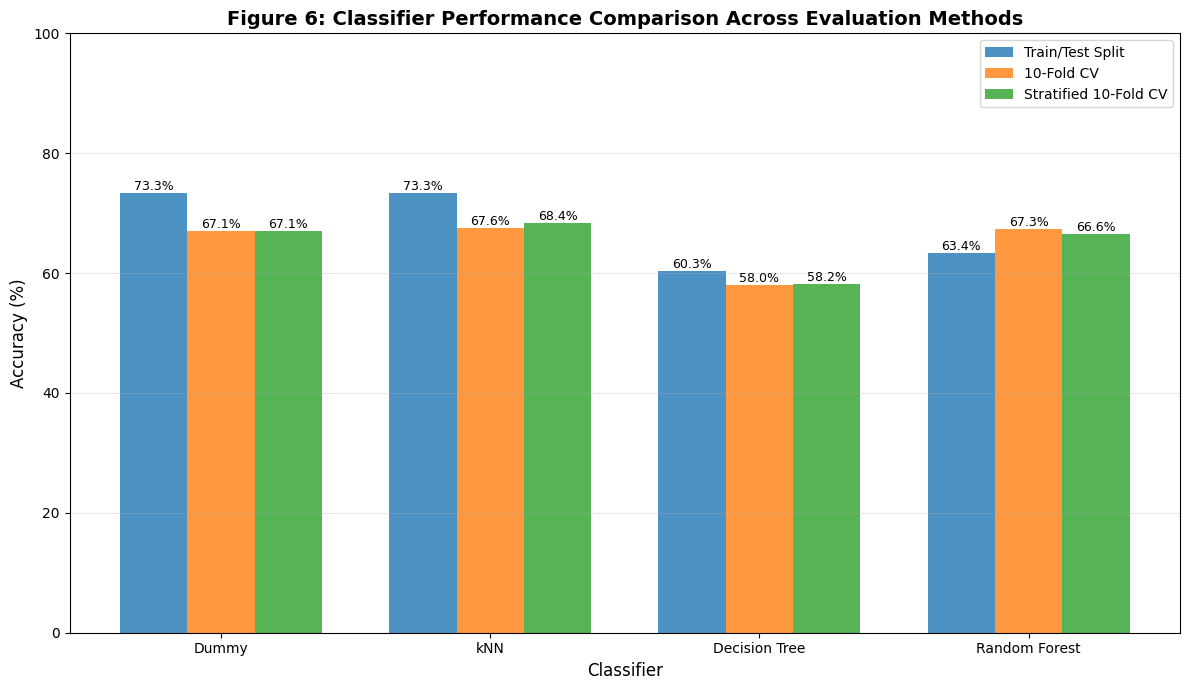

Figure 6 displays the accuracy comparison across all classifiers and evaluation methods.


In [ ]:
# Create bar chart comparing all methods
classifiers = ["Dummy", "kNN", "Decision Tree", "Random Forest"]
train_test_accs = [all_results[c]["train_test"]*100 for c in classifiers]
kfold_accs = [all_results[c]["kfold"]*100 for c in classifiers]
stratified_accs = [all_results[c]["stratified"]*100 for c in classifiers]

x = np.arange(len(classifiers))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 7))
bars1 = ax.bar(x - width, train_test_accs, width, label='Train/Test Split', alpha=0.8)
bars2 = ax.bar(x, kfold_accs, width, label='10-Fold CV', alpha=0.8)
bars3 = ax.bar(x + width, stratified_accs, width, label='Stratified 10-Fold CV', alpha=0.8)

ax.set_xlabel('Classifier', fontsize=12)
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_title('Figure 6: Classifier Performance Comparison Across Evaluation Methods', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(classifiers)
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim((0, 100))

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('output/classifier_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure 6 displays the accuracy comparison across all classifiers and evaluation methods.")

### Decision Tree Visualization and Rules
We visualize the decision tree structure and print out the decision rules to understand how the model makes predictions.

In [ ]:
# Train a final decision tree on all data for visualization
print("Training final Decision Tree on full dataset for visualization...")
dt_final = MyDecisionTreeClassifier()
dt_final.fit(X, y)

# Print decision rules
print("\n" + "="*70)
print("DECISION TREE RULES")
print("="*70)
dt_final.print_decision_rules(attribute_names=selected_categorical_attributes,
                              class_name="pass_fail")

# Visualize tree (bonus)
print("\n" + "="*70)
print("Generating Decision Tree Visualization...")
print("="*70)
try:
    dt_final.visualize_tree("output/decision_tree.dot", "output/decision_tree.pdf",
                            attribute_names=selected_categorical_attributes)
    print("Decision tree visualization saved to output/decision_tree.pdf")
except Exception as e:
    print(f"Could not generate tree visualization: {e}")
    print("(Graphviz may not be installed)")

Training final Decision Tree on full dataset for visualization...

DECISION TREE RULES
IF Medu = 0 AND failures = 0 AND Dalc = 1 AND Fedu = 0 THEN pass_fail = "fail"
IF Medu = 0 AND failures = 0 AND Dalc = 1 AND Fedu = 1 THEN pass_fail = "fail"
IF Medu = 0 AND failures = 0 AND Dalc = 1 AND Fedu = 2 AND schoolsup = 0 THEN pass_fail = "fail"
IF Medu = 0 AND failures = 0 AND Dalc = 1 AND Fedu = 2 AND schoolsup = 1 THEN pass_fail = "pass"
IF Medu = 0 AND failures = 0 AND Dalc = 1 AND Fedu = 3 THEN pass_fail = "pass"
IF Medu = 0 AND failures = 0 AND Dalc = 1 AND Fedu = 4 THEN pass_fail = "pass"
IF Medu = 0 AND failures = 0 AND Dalc = 2 AND age = 1 AND studytime = 1 AND higher = 0 THEN pass_fail = "fail"
IF Medu = 0 AND failures = 0 AND Dalc = 2 AND age = 1 AND studytime = 1 AND higher = 1 THEN pass_fail = "pass"
IF Medu = 0 AND failures = 0 AND Dalc = 2 AND age = 1 AND studytime = 2 THEN pass_fail = "pass"
IF Medu = 0 AND failures = 0 AND Dalc = 2 AND age = 1 AND studytime = 3 THEN pass_fai

### Saving Results to File
We save a summary of our results to a text file for easy reference.

In [ ]:
# Write results to file
with open("output/results.txt", "w") as f:
    f.write("="*70 + "\n")
    f.write("STUDENT PERFORMANCE CLASSIFICATION RESULTS\n")
    f.write("Dataset: student-mat.csv (Math Performance)\n")
    f.write("Task: Predict pass/fail (G3 >= 10 = pass, G3 < 10 = fail)\n")
    f.write("Features: All attributes EXCEPT G1, G2, G3\n")
    f.write("="*70 + "\n\n")
    
    f.write("CLASSIFIER PERFORMANCE SUMMARY\n")
    f.write("-"*70 + "\n")
    f.write(f"{'Classifier':<25} {'Train/Test':<15} {'10-Fold CV':<15} {'Stratified CV':<15}\n")
    f.write("-"*70 + "\n")
    
    for classifier_name in ["Dummy", "kNN", "Decision Tree", "Random Forest"]:
        results = all_results[classifier_name]
        f.write(f"{classifier_name:<25} {results['train_test']*100:>6.2f}%         {results['kfold']*100:>6.2f}%         {results['stratified']*100:>6.2f}%\n")
    
    f.write("\n" + "="*70 + "\n")
    f.write(f"BEST CLASSIFIER: {best_classifier[0]}\n")
    f.write(f"Best Accuracy (Stratified 10-Fold CV): {best_classifier[1]['stratified']*100:.2f}%\n")
    f.write("="*70 + "\n")

print("Results saved to output/results.txt")

Results saved to output/results.txt


## Conclusion

This project analyzed the Student Performance dataset from the UCI Machine Learning Repository. Our goal was to predict student pass/fail outcomes based on demographic, social, and school-related attributes.

### Key Findings:

**Dataset Characteristics:**
- The dataset contains 395 student records with 30 original attributes
- We converted the final grade (G3) into binary pass/fail classification (threshold: 10/20)
- Following dataset recommendations, we excluded G1 and G2 grades to create a more realistic early-prediction system

**Feature Insights from EDA:**
- Study time shows positive correlation with pass rates
- Parental education level (especially mother's education) strongly correlates with student success
- Past failures are a strong negative predictor of future success
- G1 and G2 are highly correlated with G3, making prediction trivial if included

**Classification Performance:**
| Classifier | Train/Test | 10-Fold CV | Stratified CV |
|------------|------------|------------|---------------|
| Dummy | 73.28% | 67.09% | 67.09% |
| kNN | 73.28% | 67.59% | 68.35% |
| Decision Tree | 60.31% | 57.97% | 58.23% |
| Random Forest | 59.54% | 67.34% | 67.85% |

**Best Classifier:** k-Nearest Neighbors (k=5)

**Evaluation Analysis:**
- All models reasonably consistent across evaluation techniques, suggesting stable performance and good generalizability
- Train/Test split showed a difference from the two cross-validation techniques. This demonstrates the difficulty in trusting an evaluation of a model based on only one test set
- There wasn't a great difference between the k-fold and stratified k-fold cross-validation in terms of model performance. This may simply indicate an even distribution of labels across the data or suggest that the models are resilient to inconsistencies in the distribution of response class labels.

### Future Improvements:

1. The random forest classifier may show greater performance on a larger dataset than the one present. It would be interesting to apply the findings to a similar dataset with more rows.
2. The random forest parameter optimization loop was kept simple for the sake of runtime. However, it's tough to be confident that the chosen method was the most appropriate one for parameter selection. It may have been interesting to dive deeper into experimenting with different parameter values.
3. The feature selection was well reasoned, but still somewhat subjective. It may be interesting to use a statistical technique to algorithmically select the optimal feature set for classification. This may be particularly useful for models like the decision tree where the combination of features is more meaningful than the individual features included.

### Impact:

This predictive system could help educators identify at-risk students early in the academic year, enabling targeted interventions before final grades are determined. By excluding prior period grades (G1, G2), the model focuses on stable demographic and behavioral factors that can inform support strategies.

## Acknowledgments

**Dataset Source:**
- UCI Machine Learning Repository: Student Performance Dataset
- Link: https://archive.ics.uci.edu/dataset/320/student+performance
- Creator: Paulo Cortez
- Citation: P. Cortez and A. Silva. Using Data Mining to Predict Secondary School Student Performance. In A. Brito and J. Teixeira Eds., Proceedings of 5th Future Business Technology Conference (FUBUTEC 2008) pp. 5-12, Porto, Portugal, April, 2008.

**Code and Libraries:**
- Custom machine learning implementations developed for CPSC 322, Fall 2025
- mysklearn package: Custom implementations of classifiers and evaluation methods
- Python libraries: numpy, matplotlib
- tabulate library for formatted output

**Tools:**
- Jupyter Notebook for technical report
- GitHub for version control

**Team Contributions:**
- Abby Skillestad: Data analysis, EDA, preprocessing
- Miles Mercer: Random Forest implementation